# Library:

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [ ]:

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import os
from os.path import isfile
import random
import json
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow
import cv2 as cv
from PIL import Image

import tensorflow_addons as tfa


In [ ]:
# make dict classes with its unique int value
mclass = {0:'Mouse Detected', 1:'Mouse Not Detected'} 

# Layers Building:

### Building Components

In [ ]:

# Build base CNN layer EfficientNet using Keras
def build_cnn_layer():
    
  cnn_layer = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),    #change input size if needed
    alpha=1.0,
    include_top=False,
    weights='imagenet')
  
  # # only allowing last 5 layer of mobileNet to train
  # for layer in cnn_layer.layers[:-7]:
  #   layer.trainable = False

  return cnn_layer


def customCnn_layer(inputs):

  x = inputs

  x = layers.Conv2D(128, 3, padding='same', activation='relu', name='bl_1')(x)
  x = layers.MaxPooling2D(name='bl_2')(x)
  x = layers.Conv2D(128, 3, padding='same', activation='relu', name='bl_3')(x)
  x = layers.MaxPooling2D(name='bl_4')(x)
  x = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_5')(x)


  return x


# Flatten
def flatten_layer(inputs):

  x = inputs
  flattened_layer = Flatten()(x)

  return flattened_layer


####################
# Creating 2 Heads #
####################


# Classifier Head:
def classify_layer(inputs, num_classes=2):

  x = inputs
  x = Dense(128, activation='relu', name='cl_1')(x)
  x = Dense(64, activation='relu', name='cl_2')(x)
  x = Dense(32, activation='relu', name='cl_3')(x)
  class_head = Dense(num_classes, activation='softmax', name='cl_head')(x)

  return class_head



# Regression Head:
def regress_layer(inputs, num_coord=4):

  x = inputs
  x = Dense(128, activation='relu', name='bb_1')(x)
  x = Dense(64, activation='relu', name='bb_2')(x)
  x = Dense(32, activation='relu', name='bb_3')(x)
  regress_head = Dense(num_coord, activation='sigmoid', name='bb_head')(x)

  return regress_head



### Combining components:

In [ ]:

def final_model():

  inputs = tf.keras.Input((224,224,3))

  #adding cnn layer
  base_model = build_cnn_layer()   # build varaible to store the function returned value.
  x = base_model(inputs)           # input the data in base_model using functional API mtd.


  # #adding custom cnn layer for [freezing accuracy issue]{for testig purpose}
  # x = customCnn_layer(x)

  # adding flatten layer
  x = flatten_layer(x)

  # adding regression head
  regress_head = regress_layer(x)

  #adding classifier head
  classify_head = classify_layer(x)


  return  tf.keras.Model(inputs = inputs, outputs = [classify_head, regress_head])



In [ ]:
# model = final_model()

# model.summary()



Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['input_23[0][0]']               
 al)                                                                                              
                                                                                                  
 flatten_8 (Flatten)            (None, 62720)        0           ['mobilenetv2_1.00_224[0][0]']   
                                                                                            

In [ ]:
num_classes = 2


#create the common input layer
input_shape = (224, 224, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
# x = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
x = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
x = layers.MaxPooling2D(name='bl_3')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(x)
x = layers.MaxPooling2D(name='bl_5')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(x)
x = layers.MaxPooling2D(name='bl_7')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu', name='bl_8')(x)
x = layers.MaxPooling2D(name='bl_9')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu', name='bl_10')(x)
x = layers.MaxPooling2D(name='bl_11')(x)
x = layers.Flatten(name='bl_12')(x)


#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(x)
classifier_branch = layers.Dense(64, activation='relu', name='cl_2')(x)
classifier_branch = layers.Dense(32, activation='relu', name='cl_3')(x)
classifier_branch = layers.Dense(32, activation='relu', name='cl_3')(x)
classifier_branch = layers.Dense(num_classes, activation='softmax', name='cl_head')(classifier_branch)  



#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(x)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)


model = tf.keras.Model(input_layer, outputs=[classifier_branch,locator_branch])

model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_2 (Conv2D)                  (None, 224, 224, 16  448         ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 bl_3 (MaxPooling2D)            (None, 112, 112, 16  0           ['bl_2[0][0]']                   
                                )                                                           

# Data Collection

1. Collecting data for Classification:
  - Making dataset consist of images, class_id, coord.
  - Images consist of 0:mouse and 1:non-mouse. 
  - for classification keep the coords 0's.

2. Collecting data for Regression head:
  - Making dataset consist of images, class_id, coord.
  - Images consist of annotated images of mouse and non-mouse (no annotation).
  - for regression keep mouse coord, rest non-mouse coords as 0's.
   




## Getthing the Classification data and merging them

### Getting X:

In [ ]:
def x_classif_data(x_path, no_mouse=False):

    # get this Image file [in sequence]
    xdata = [x_path.format(i) for i in range(0, 700)]


    # check if above exist then import then get the file in list
    fileX = [f for f in xdata if isfile(f)]
    print(len(fileX))


    if no_mouse==False:

      ### now getting the content of the fileX in csv format so that we can merge them in pd dataframes
      with open('/content/x_classif_mouse_training.csv','w') as f:
        for x in fileX:
          f.write(str(x))
          f.write('\n')

    else:

      ### now getting the content of the fileX in csv format so that we can merge them in pd dataframes
      with open('/content/x_classif_no_mouse_training.csv','w') as f:
        for x in fileX:
          f.write(str(x))
          f.write('\n')




path = "/content/classification_data/mouse/Frame({}).jpg"
x_classif_data(path, no_mouse=False)


path = "/content/classification_data/no_mouse/Frame({}).jpg"
x_classif_data(path, no_mouse=True)


94
94


### Getting Y:

In [ ]:
# making the y_data csv file consist of class_ID as 0 len x_data = len_y_data

def y_classif_data(x_path, no_mouse=False):

    # get this Image file [in sequence]
    xdata = [x_path.format(i) for i in range(0, 700)]

 

    # check if above exist then import then get the file in list
    fileX = [f for f in xdata if isfile(f)]
    print(len(fileX))


    if no_mouse == False:

      # writing 0 as class_id for image paths
      with open('/content/y_classif_mouse_training.csv','w') as f:

        for i in range(0,len(fileX)):
          
          lst = []

          
          # converting the label which is in string to num created in dic
          for key, value in mclass.items():
            if value == 'mouse':
              
              l = key
          
        
          x = 0
          y = 0
          w = 0
          h = 0

          lst.append(l)
          lst.append(x)
          lst.append(y)
          lst.append(w)
          lst.append(h)
            
          
          with open('/content/y_classif_mouse_training.csv', 'a') as fout:
              
            y_csv_output = csv.writer(fout)
            y_csv_output.writerow(lst)

          lst.clear()  # list cleared

    else:
      
      # writing 0 as class_id for image paths
      with open('/content/y_classif_no_mouse_training.csv','w') as f:

        for i in range(0,len(fileX)):
          
          lst = []

          
          # converting the label which is in string to num created in dic
          for key, value in mclass.items():
            if value == 'no_object':
                
                l = key

       
          x = 0
          y = 0
          w = 0
          h = 0

          lst.append(l)
          lst.append(x)
          lst.append(y)
          lst.append(w)
          lst.append(h)
            
          
          with open('/content/y_classif_no_mouse_training.csv', 'a') as fout:
              
            y_csv_output = csv.writer(fout)
            y_csv_output.writerow(lst)

          lst.clear()  # list cleared
    




path1 = "/content/classification_data/mouse/Frame({}).jpg"
y_classif_data(path1, False)

path2 = "/content/classification_data/mouse/Frame({}).jpg"
y_classif_data(path2, True)



94
94


### Combine Classsifying X and Y

In [ ]:

def classif_combine_xy(x_mouse_csv, x_no_mouse_csv, y_mouse_csv, y_no_mouse_csv):


  ### Pandas work to get y_train.csv [consist of class + coordinates] ###
  y1_data = pd.read_csv(y_mouse_csv, names = ['class','x','y','w','h'])
  y1_df = pd.DataFrame(data = y1_data) 

  y2_data = pd.read_csv(y_no_mouse_csv, names = ['class','x','y','w','h'])
  y2_df = pd.DataFrame(data = y2_data) 


  ## Pandas work to get x_train.csv [consist images] ###
  x1_data = pd.read_csv(x_mouse_csv, names= ['path'])
  x1_df = pd.DataFrame(data = x1_data) 

  x2_data = pd.read_csv(x_no_mouse_csv, names= ['path'])
  x2_df = pd.DataFrame(data = x2_data) 

  
  # concate x1,x2
  X_classif_df = pd.concat([x1_df, x2_df], axis=0)
  # concate y1, y2
  Y_classif_df = pd.concat([y1_df, y2_df], axis = 0)


  # verify
  print('x',len(X_classif_df))
  print('y',len(Y_classif_df))
  

  ####combine dataframe [consist of path + coordinates + class]  #######
  classif_training_df = pd.concat([X_classif_df, Y_classif_df], axis=1)


  return classif_training_df
  


pathx1 = '/content/x_classif_mouse_training.csv'
pathx2 = '/content/x_classif_no_mouse_training.csv'

pathy1 = '/content/y_classif_mouse_training.csv'
pathy2 = '/content/y_classif_no_mouse_training.csv'


classif_df = classif_combine_xy(pathx1, pathx2, pathy1, pathy2)

classif_train = classif_df[:150]
classif_test = classif_df[151:]

print('train shape',classif_train.shape)
print('test shape',classif_test.shape)




x 188
y 188
train shape (150, 6)
test shape (37, 6)


## Getting Localizing Data and merging them;

### Getting X:

In [ ]:

def x_localiz_data(x_path, objectExist=True):

  if objectExist == True:

    # get this Image file [in sequence]
    xdata = [x_path.format(i) for i in range(0, 700)]


    # check if above exist then import then get the file in list
    fileX = [f for f in xdata if isfile(f)]
    print(len(fileX))


    ### now getting the content of the fileX in csv format so that we can merge them in pd dataframes
    with open('/content/x_localiz_training.csv','w') as f:
      for x in fileX:
        f.write(str(x))
        f.write('\n')

  else:

    # get this Image file [in sequence]
    xdata = [x_path.format(i) for i in range(0, 500)]


    # check if above exist then import then get the file in list
    fileX = [f for f in xdata if isfile(f)]
    print(len(fileX))


    ### now getting the content of the fileX in csv format so that we can merge them in pd dataframes
    with open('/content/x_emptyobject_training.csv','w') as f:
      for x in fileX:
        f.write(str(x))
        f.write('\n')


# for getting image path of localization image folder
localiz_img_path = "/content/localization_data/Frame({}).jpg"

# for getting image path of empty class image folder
empty_class_img_path = "/content/emptyObject_data/Frame({}).jpg"



# calling for localize x data
x_localiz_data(localiz_img_path, True)


# calling for empytyc class x data
x_localiz_data(empty_class_img_path, False)



86
53


### Getting Y:

In [ ]:

def y_data(y_path, objectExist=True):

  # initialize 
  l,x,y,w,h = 0,0,0,0,0      #some json fetching values
  mclass = {'mouse': 0, 'No_Object':1}  # make dict classes with its unique int value
  lst = []                   # for storing json collected values
  global rtxt_files

  if objectExist==True:

    # START
    # get this Image file [in sequence]
    ydata = [y_path.format(i) for i in range(0, 700)]

    # check if above exist then import then get the file in list
    fileY = [f for f in ydata if isfile(f)]
    print('y data length:',len(fileY))

    lst = []

    for i in fileY:
      
      rtxt_files = open(i, 'r')

      mfile = rtxt_files.readline()
      
      lst.append(mfile)

    print('lenght of list',len(lst))

    wtxt_file = open('/content/y_path.txt','w')
    

    for i in lst:
      wtxt_file.write(i)



    # rtxt_files.close()
    wtxt_file.close()


    # read tab-delimited file
    with open('y_path.txt','r') as fin:
        cr = csv.reader(fin, delimiter=' ')
        filecontents = [line for line in cr]


    # write comma-delimited file (comma is the default delimiter)
    with open('y_localiz_training.csv','w') as fou:
        cw = csv.writer(fou, quotechar='', quoting=csv.QUOTE_NONE)
        cw.writerows(filecontents)


  else:

    ydata = [y_path.format(i) for i in range(0, 700)]

    # check if above exist then import then get the file in list
    fileY = [f for f in ydata if isfile(f)]
    print('non object y data length:',len(fileY))


    print('length of fileY', len(fileY))
    for _ in range(0, len(fileY) ):

      lst = []

        
      # converting the label which is in string to num created in dic
      for key, value in mclass.items():
        if key == 'No_Object':
            
            l = value

      x = 0
      y = 0
      w = 0
      h = 0

      lst.append(l)
      lst.append(x)
      lst.append(y)
      lst.append(w)
      lst.append(h)
        
      
      with open('/content/y_emptyobject_training.csv', 'a') as fout:
          
        y_csv_output = csv.writer(fout)
        y_csv_output.writerow(lst)

      lst.clear()  # list cleared 



# localization y-data path 
localiz_json = "/content/localization_data/Frame({}).txt"


# non existing class object path
empty_class = "/content/emptyObject_data/Frame({}).jpg"



# calling when object does exist in image
y_data(localiz_json, objectExist = True)


# calling when object doesn't exist in image
y_data(empty_class, objectExist = False)


y data length: 86
lenght of list 86
non object y data length: 53
length of fileY 53


### Combine localize X and Y:

In [ ]:

def combine_xy_csv(x_csv_path, y_csv_path, objectExist=True):

  ### Pandas work to get y_train.csv [consist of class + coordinates] ###
  y_data = pd.read_csv(y_csv_path, names= ['class', 'x', 'y', 'w', 'h'])
  y_df = pd.DataFrame(data=y_data) 

  ## Pandas work to get x_train.csv [consist images] ###
  x_data = pd.read_csv(x_csv_path, names= ['path'])
  x_df = pd.DataFrame(data = x_data) 


  if objectExist == True:
    
    # verify
    print('x',x_df.shape)
    print('y',y_df.shape)
  
    # spitting x,y df into train test:
    x_train_df = x_df[:60]
    x_test_df = x_df[61:]

    y_train_df = y_df[:60]
    y_test_df = y_df[61:]


    ####combine dataframe [consist of path + coordinates + class]  #######
    train_df = pd.concat([x_train_df, y_train_df], axis="columns")
    train_df.head()

    test_df = pd.concat([x_test_df, y_test_df], axis="columns")
    test_df.head()


  else:

    print('x',x_df.shape)
    print('y',y_df.shape)

    # spitting x,y df into train test:
    x_train_df = x_df[:39]
    x_test_df = x_df[40:]

    y_train_df = y_df[:39]
    y_test_df = y_df[40:]
      
    ###combine dataframe [consist of path + coordinates + class]  #######
    train_df = pd.concat([x_train_df, y_train_df], axis="columns")
    train_df.head()

    test_df = pd.concat([x_test_df, y_test_df], axis="columns")
    test_df.head()

  return train_df, test_df


localize_x = '/content/x_localiz_training.csv'
localize_y = '/content/y_localiz_training.csv'

# non_object_x = '/content/x_emptyobject_training.csv'
# non_object_y = '/content/y_emptyobject_training.csv'


# calling localize
local_train_df, local_test_df = combine_xy_csv(localize_x, localize_y, True)

print('train',local_train_df.shape)
print('test',local_test_df.shape)


# # calling emptyObject
# notobject_train_df, notobject_test_df = combine_xy_csv(non_object_x, non_object_y, False)

# print('train',notobject_train_df.shape)
# print('test',notobject_test_df.shape)


x (86, 1)
y (86, 5)
train (60, 6)
test (25, 6)


# Data Preprocessing:
1. Will creating image_extractor funct from path.

2. bring all the images from the path into an array will make x_data_gen funct.

3. Also w'll define input x,y for model.fit(). 
For 2 times compiling the model.



### Creating image_extractor:

In [ ]:


# preprocessing function()
def img_preprocess(path):

   # read the file from the path
  image = tf.io.read_file(path)

  #now to decode the file from previous readfile because it read the file and stored it in Machine language now we have to decode it 
  image = tf.image.decode_jpeg(image, channels=3)
  
  # image resize
  # image = tf.image.resize(image, [224,224]) / 255. # EfficientNet needs this size
  
  # image resize
  image = tf.image.resize(image, [224,224]) # EfficientNet needs this size
 
  # labels = to_categorical(label, num_classes=2)  # num_classes are 2 ->(box,mouse)

  return image


# generating image matrix from path
def x_data_gen(data):
  
  x_data_arr = []
  

  for i in data:
    
    # getting img matrix by passing paths
    img = img_preprocess(i)

    x_data_arr.append(img)

  return np.array(x_data_arr)





### Preparing the arguments to pass in round_01 function:

In [ ]:
# paths to pass
localize_x = '/content/x_localiz_training.csv'
localize_y = '/content/y_localiz_training.csv'


# calling combine_xy_csv to combine localizing x,y and return its train test
local_train_df, local_test_df = combine_xy_csv(localize_x, localize_y, True)


x (86, 1)
y (86, 5)


### Arranging X,Y for [1st round of training]:

In [ ]:

def round_01_xy(local_train_df,local_test_df):

  print('local_train_df-shape',local_train_df.shape)
  print('local_test_df-shape',local_test_df.shape)

  x_loc_train = local_train_df['path']
  y_loc_train = local_train_df.iloc[:,1:]

  x_loc_test = local_test_df['path']
  y_loc_test = local_test_df.iloc[:,1:]


  # convert x to array
  x_loc_train = np.array(local_train_df['path'])
  x_loc_test = np.array(local_test_df['path'])


  # train X,Y loc data to be inserted for 1st round of training in model.fit
  X_loc_train = x_data_gen(x_loc_train)
  Y_loc_train = { 'cl_head': np.array(y_loc_train['class']), 
            'bb_head': np.array(y_loc_train[['x','y','w','h']]) }

  # for verification
  print('length of X_loc_train',len(X_loc_train))
  print('length of Y_loc_train',len(Y_loc_train))


  # test X,Y loc data to be inserted for 1st round of training in model.fit
  X_loc_test = x_data_gen(x_loc_test)
  Y_loc_test = { 'cl_head': np.array(y_loc_test['class']), 
              'bb_head': np.array(y_loc_test[['x','y','w','h']]) }

  # for verification
  print('length of X_loc_test',len(X_loc_test))
  print('length of Y_loc_test',len(Y_loc_test))

  # for verification
  # print(Y_loc_test)

  return X_loc_train, Y_loc_train, X_loc_test, Y_loc_test



X_loc_train, Y_loc_train, X_loc_test, Y_loc_test = round_01_xy(local_train_df, local_test_df, )


local_train_df-shape (60, 6)
local_test_df-shape (25, 6)
length of X_loc_train 60
length of Y_loc_train 2
length of X_loc_test 25
length of Y_loc_test 2


### Preparing the argument to pass in round_02 function:

In [ ]:

# paths to pass
pathx1 = '/content/x_classif_mouse_training.csv'
pathx2 = '/content/x_classif_no_mouse_training.csv'

pathy1 = '/content/y_classif_mouse_training.csv'
pathy2 = '/content/y_classif_no_mouse_training.csv'


localize_x = '/content/x_localiz_training.csv'
localize_y = '/content/y_localiz_training.csv'


# collecting the classif data consist of mouse and non_mouse images with coords 0
classif_df = classif_combine_xy(pathx1, pathx2, pathy1, pathy2)
# splitting classif_df into train and test
classif_train_df = classif_df[:150]
classif_test_df = classif_df[151:]


# [NOTE]: no need to split into train test it already returned as train,test
# calling combine_xy_csv to combine localizing x,y and return its train test
local_train_df, local_test_df = combine_xy_csv(localize_x, localize_y, True)



x 188
y 188
x (86, 1)
y (86, 5)


### Arranging X,Y for [2nd round of training]:

In [ ]:

def round_02(local_train_df, local_test_df, classif_train_df, classif_test_df):

  ### combine localize_train and classif_train###
  combined_train_df = pd.concat( [local_train_df, classif_train_df], 
                            axis = 0, ignore_index=True )
  print('combine_train shape: ',combined_train_df.shape)   

  # shuffle the DataFrame rows
  combined_train_df = combined_train_df.sample(frac = 1, ignore_index=True)

  combined_train_df.head()   # for verification



  ### combine localize_test and nonobject_test ###
  combined_test_df = pd.concat( [local_test_df, classif_test_df], 
                           axis = 0, ignore_index=True )
  print('combine_test shape: ',combined_test_df.shape)   


  # shuffle the DataFrame rows
  combined_test_df = combined_test_df.sample(frac = 1, ignore_index=True)

  combined_test_df.head()   # for verification


  # Now extracting X,Y from cobined train, test df for model.fit() in 2nd round.
  x_combined_train = np.array(combined_train_df['path'])
  x_combined_test = np.array(combined_test_df['path'])

  y_combine_train = combined_train_df.iloc[:,1:]
  y_combine_test = combined_test_df.iloc[:,1:]


  # train X,Y non data to be inserted for 2st round of training in model.fit
  X_combine_train = x_data_gen(x_combined_train)
  Y_combine_train = { 'cl_head': np.array(y_combine_train['class']), 
            'bb_head': np.array(y_combine_train[['x','y','w','h']]) }

  # for verification
  print('length of X_combine_train',len(X_combine_train))
  print('length of Y_combine_train',len(Y_combine_train))

  
  # test X,Y non data to be inserted for 2nd round of training in model.fit
  X_combine_test = x_data_gen(x_combined_test)
  Y_combine_test = { 'cl_head': np.array(y_combine_test['class']), 
            'bb_head': np.array(y_combine_test[['x','y','w','h']]) }

  # for verification
  print('length of X_combine_test',len(X_combine_test))
  print('length of Y_combine_test',len(Y_combine_test))
  
  
  
  return X_combine_train, Y_combine_train, X_combine_test, Y_combine_test, combined_train_df
  


# calling the function and getting the returned train test X,Y for model.fit() 
X_combine_train, Y_combine_train, X_combine_test, Y_combine_test, combined_train_df = round_02(local_train_df, local_test_df, classif_train_df, classif_test_df)




combine_train shape:  (210, 6)
combine_test shape:  (62, 6)
length of X_combine_train 210
length of Y_combine_train 2
length of X_combine_test 62
length of Y_combine_test 2


# Testing coordinates on image:


Why we are testing?

1. to check if xmin,xmax... is the format of what the labelimg has provided us in txt file or it has provided us x,y,w,h.

2. Also to understand how the coordinates as adjusted if the size of the image gets changed.

[CONCLUSION]:
- coordinates are not in xmin,xmax... instead it is normalized x,y,w,h w.r.t the image size.
[x = center, y = center, w = width, h = height]
- hence before plotting we have to denormalised it and give the required coord for rectangle.

- For the plt.rectangle we need xmin,ymin,w,h so we have to derive xmin,ymin from x,y,w,h.



x- 0.447656 y- 0.55625 w- 0.157812 h- 0.308333
(224, 224, 3)
224
224
denorm_x: 100.274944 denorm_y: 124.60000000000001 denorm_w: 35.349888 denorm_h: 69.066592
denorm_xmin- 82.60000000000001 denorm_ymin- 90.06670400000002


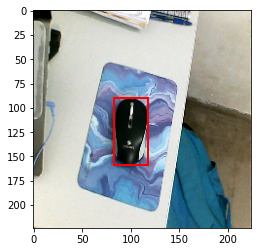

In [ ]:
# CONVERT IMGE PATH TO IMAGE MATRIX
def load_img_vis(input_img):

  #reads the image using tf.io it just simply returns file as it is
  image = tf.io.read_file(input_img) 

  # image we got from previous step is the image in our dataset which is .png format now decoding it
  image = tf.image.decode_jpeg(image, channels=3)

  # image channel was 1(gray scale) converting it to 3(bgr) AS matplot does accepts dim(x,y,1)
  # image = tf.image.grayscale_to_rgb(image)

  # type casting of image dtype from uint8 to float32
  # [NOTE] ---> NORMALIZED PIXELS DOESN'T AFFECT COORDINATEs.
  image = tf.cast(image,tf.float32) / 255. # Only for testing purpose, model automatically does this

  # # image resize
  image = tf.image.resize(image, [224,224])

  print(image.shape)
  img_width = image.shape[1] 
  img_height = image.shape[0]

  print(img_width)
  print(img_height)

  return image, img_width, img_height




# ADD BBOX
def add_bbox_on_img(df,index):
  
  x, y, w, h = df.iloc[index][2:]
  print('x-',x, 'y-',y, 'w-',w, 'h-',h)
  
  # plot patch
  img,img_width,img_height = load_img_vis(df['path'].iloc[index])


  ############################################
  ### RESCALING THE COORD W.R.T IMAGE SIZE ###
  ############################################

  # x,y are center normalized by the width and height of the image
  # w,h are the width n height of bbox normalized by image widht,height
  width = w*img_width
  height = h*img_height
  x = (x)*img_width
  y = (y)*img_height

  print('denorm_x:',x ,'denorm_y:',y, 'denorm_w:',width, 'denorm_h:',height)


  ### calculate xmin,ymin from denormalize x,y,w,h bcz rectangle need xmin,xmax##
  xmin = (2*x-width)/2 
  ymin = (2*y-height)/2
  print('denorm_xmin-',xmin,'denorm_ymin-',ymin)

  ## build rectangular patch
  rectangle = plt.Rectangle((xmin,ymin), width, height, fill = False, linewidth=2, edgecolor='r')

  # print('image array:', np.array(img))

  fig, ax = plt.subplots()
  ax.imshow(img)
  # finally plotting patch
  ax.add_patch(rectangle)
  plt.show()



# randomly creating the value
i = np.random.randint(0,40)

add_bbox_on_img(local_train_df,i)



# Round-01:
## Compile & fit

In [ ]:

# This learning rate fits better with SGD over adam for this situation
# compiling 
# SGD(learning_rate=0.0001)
model.compile( optimizer = SGD(learning_rate=0.0001),
              loss = {'cl_head':tf.keras.losses.SparseCategoricalCrossentropy(), 'bb_head': tf.keras.losses.MeanSquaredError()},
              metrics = {'cl_head':['accuracy'], 'bb_head': ['mse'] } )

batch_size = 5


# training-[1st round with localizing data]
model.fit(x = X_loc_train, y = Y_loc_train,
          validation_data = (X_loc_test,Y_loc_test), 
          batch_size = batch_size, epochs = 100,
          steps_per_epoch= len(X_loc_train)/batch_size)



Epoch 1/100
12/12 [==============================] - 2s 43ms/step - loss: 0.1814 - cl_head_loss: 0.0011 - bb_head_loss: 0.1804 - cl_head_accuracy: 1.0000 - bb_head_mse: 0.1804 - val_loss: 0.2066 - val_cl_head_loss: 2.9562e-05 - val_bb_head_loss: 0.2066 - val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.2066
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 0.1627 - cl_head_loss: 4.8725e-05 - bb_head_loss: 0.1626 - cl_head_accuracy: 1.0000 - bb_head_mse: 0.1626 - val_loss: 0.1890 - val_cl_head_loss: 2.3969e-05 - val_bb_head_loss: 0.1890 - val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.1890
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1347 - cl_head_loss: 6.4953e-05 - bb_head_loss: 0.1346 - cl_head_accuracy: 1.0000 - bb_head_mse: 0.1346 - val_loss: 0.1703 - val_cl_head_loss: 2.7955e-05 - val_bb_head_loss: 0.1703 - val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.1703
Epoch 4/100
12/12 [==============================] - 0s 14ms/s

In [ ]:
# When Using MobileNet
# val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.0790

# after adding custom layer
# val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.0193


# changing the mbileNet from V3-Large to V2
# val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.0116


# using all the layers of mobileNet v2 without frezzing them
# val_cl_head_accuracy: 1.0000 - val_bb_head_mse: 0.0162


# using all the layers of MobileNetV3 large
# val_cl_head_accuracy: 0.8400 - val_bb_head_mse: 0.0756


# Freezing Process:
- Before 2nd round of training we need to freeze rest of the layers and train only on classif layer.

In [ ]:

# for layer in model.layers:
#     if layer.name.startswith(('cl','Mob')):
#         layer.trainable = True
#     else:
#       layer.trainable=False




### Using 2nd model for freezing ####
# for layer in model.layers:
#     if layer.name.startswith('bl_'):
#         layer.trainable = False
        


for layer in model.layers:
    if layer.name.startswith('bb_'):
        layer.trainable = False

# for layer in model.layers:
#     if layer.name.startswith('Mob'):
#         layer.trainable = False



In [ ]:
for layer in model.layers:
  layer.trainable = True


In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_2 (Conv2D)                  (None, 224, 224, 16  448         ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 bl_3 (MaxPooling2D)            (None, 112, 112, 16  0           ['bl_2[0][0]']                   
                                )                                                           

In [ ]:
# Total params: 4,361,286
# Trainable params: 1,520,454
# Non-trainable params: 2,840,832



# freezed only bb
# Total params: 4,361,286
# Trainable params: 1,501,666
# Non-trainable params: 2,859,620





# Round-02
## Compile & Fit

In [ ]:

# SGD(learning_rate=0.01)
# compiling 
model.compile( optimizer = SGD(learning_rate=0.00001),
              loss = {'cl_head':tf.keras.losses.SparseCategoricalCrossentropy(), 'bb_head': tf.keras.losses.MeanSquaredError()},
              metrics = {'cl_head':['accuracy'], 'bb_head': ['mse']} )

batch_size = 8


# X_combine_train, Y_combine_train, X_combine_test, Y_combine_test

# training [1st round with localizing data]
model.fit(x = X_combine_train,y = Y_combine_train,
          validation_data = (X_combine_test,Y_combine_test), 
          batch_size = batch_size, epochs = 100,
          steps_per_epoch= len(X_combine_train)/batch_size)




Epoch 1/100
26/26 [==============================] - 2s 46ms/step - loss: 1.9846 - cl_head_loss: 1.7447 - bb_head_loss: 0.2399 - cl_head_accuracy: 0.7048 - bb_head_mse: 0.2399 - val_loss: 1.9468 - val_cl_head_loss: 1.6660 - val_bb_head_loss: 0.2809 - val_cl_head_accuracy: 0.5968 - val_bb_head_mse: 0.2809
Epoch 2/100
26/26 [==============================] - 0s 15ms/step - loss: 0.7112 - cl_head_loss: 0.5247 - bb_head_loss: 0.1865 - cl_head_accuracy: 0.8476 - bb_head_mse: 0.1865 - val_loss: 0.9447 - val_cl_head_loss: 0.7113 - val_bb_head_loss: 0.2334 - val_cl_head_accuracy: 0.7258 - val_bb_head_mse: 0.2334
Epoch 3/100
26/26 [==============================] - 0s 17ms/step - loss: 0.3951 - cl_head_loss: 0.2473 - bb_head_loss: 0.1478 - cl_head_accuracy: 0.9048 - bb_head_mse: 0.1478 - val_loss: 0.8798 - val_cl_head_loss: 0.6870 - val_bb_head_loss: 0.1928 - val_cl_head_accuracy: 0.6129 - val_bb_head_mse: 0.1928
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 0.2662 -

In [ ]:
# After freezing bb_ head.
# val_cl_head_accuracy: 0.5806 - val_bb_head_mse: 0.3184


# after adding custom cnn layer.
# val_cl_head_accuracy: 0.4355 - val_bb_head_mse: 0.1381


# after adding custom cnn layer after freezing bb and mobileNet.
# val_cl_head_accuracy: 0.5806 - val_bb_head_mse: 0.1306

# replacing to mobileNet v2 
# val_cl_head_accuracy: 0.4032 - val_bb_head_mse: 0.1622

# increase batch size to 8
# val_cl_head_accuracy: 0.4032 - val_bb_head_mse: 0.1613


# used the whole MobileNet layers without frezzing.[Increased really well]
# val_cl_head_accuracy: 0.8065 - val_bb_head_mse: 0.1471


# used the whole Mobnet layer and reduced the batchsize to 4 [till now top][first trained on batch 8 then on 4]
# val_cl_head_accuracy: 0.8871 - val_bb_head_mse: 0.1450

# used mobNetV3Large using all the layers at batch size=4
# val_cl_head_accuracy: 0.8387 - val_bb_head_mse: 0.2368


# used custom layer instead of mobileNet [ Top most one]
# val_cl_head_accuracy: 0.9516 - val_bb_head_mse: 0.1049






# Prediction phase;

In [ ]:

# CONVERT IMGE PATH TO IMAGE MATRIX
def load_img_vis(input_img):

  #reads the image using tf.io it just simply returns file as it is
  image = tf.io.read_file(input_img) 

  # image we got from previous step is the image in our dataset which is .png format now decoding it
  image = tf.image.decode_jpeg(image, channels=3)

  # type casting of image dtype from uint8 to float32
  # [NOTE] ---> NORMALIZED PIXELS DOESN'T AFFECT COORDINATEs.
  image = tf.cast(image,tf.float32) / 255. # Only for testing purpose, model automatically does this

  # # image resize
  image = tf.image.resize(image, [224,224])

  # INCREASE DIMENSIONS, while plotting w'll reduce this dimension
  image = tf.expand_dims(image, 0)

  print('Image shape is: ',image.shape)
  img_width = image.shape[1] 
  img_height = image.shape[2]

  print('Image width:',img_width)
  print('Image height:',img_height, end='\n\n')


  return image, img_width, img_height





# PREDICT AND ADD BBOX
def predict(df,index):


  # x,y,w,h = actual_coord
  # print('x-',x, 'y-',y, 'w-',w, 'h-',h)

  # get img, img_widht,img_height
  img,img_width,img_height = load_img_vis(df['path'].iloc[index])


  #################
  # model.predict #
  #################

  # model.predict it return array of image_class[10] + regression[4] for each inserted image
  pred_class, pred_bbox = model.predict(img)


  # predicted class of image
  class_predict = np.argmax(pred_class)  #max probability class
  print('max probability class:', class_predict, end='\n')
  
  for i in mclass.keys():
    if i == class_predict:
      print('Class is:',mclass[i],end='\n\n')
     


  # actual bbox coordinates
  actual_coord = df[['x','y','w','h']].iloc[index]
  print('Actual coordinates:',list(actual_coord), end='\n\n') 

  # predicted bbox coordinates
  reg_predict = pred_bbox[0]
  print('predicted bbox coordinates:', reg_predict, end='\n\n')


  x,y,w,h = reg_predict
  print('Predicted x,y,w,h:',end='\n')
  print('pred x:{0}\npred y:{1}\npred w:{2}\npred h:{3}'.format(x,y,w,h),end='\n\n')




  #[NOTE]:
  # x,y are center normalized by the width and height of the image
  # w,h are the width n height of bbox normalized by image widht,height

  ############################################
  ### RESCALING THE COORD W.R.T IMAGE SIZE ###
  ############################################
    
    
  width = w*img_width
  height = h*img_height
  x = (x)*img_width
  y = (y)*img_height
  print('Rescaling the x,y,w,h with respect to image size: ', end='\n')
  print('denorm x:{0}\ndenorm y:{1}\ndenorm w:{2}\ndenorm h:{3}'.format(x,y,w,h))


  ### calculate xmin,ymin from denormalize x,y,w,h bcz rectangle need xmin,xmax##
  xmin = (2*x-width)/2 
  ymin = (2*y-height)/2
  print('Calculated xmin ymin for rectangle as bbox building:', end='\n')
  print('denorm xmin-{0}\ndenorm ymin:{1}'.format(xmin,ymin), end='\n\n')



  # [checking]: If class has not detecd mouse then no bbox should be drawn, hence make all coords = 0
  if class_predict == 1:
    xmin, ymin, width, height = 0, 0, 0 ,0
    


  ## build rectangular patch
  rectangle = plt.Rectangle((xmin,ymin), width, height, fill = False, linewidth=2, edgecolor='r')


  fig, ax = plt.subplots()

  #REDUCE DIMENSION, as our image has 4-dim to 3-dim bcz plt accepts 3 dim only  
  img = tf.squeeze(img, axis=0) 
  ax.imshow(img)
  # finally plotting patch
  ax.add_patch(rectangle)
  plt.show()


  # Printing class once again:
  for i in mclass.keys():
    if i == class_predict:
      print('Class is:',mclass[i],end='\n\n')



### Calling the predicted function

69
Image shape is:  (1, 224, 224, 3)
Image width: 224
Image height: 224

1/1 [==============================] - 0s 24ms/step
max probability class: 1
Class is: Mouse Not Detected

Actual coordinates: [0.0, 0.0, 0.0, 0.0]

predicted bbox coordinates: [0.49730685 0.4987729  0.49445868 0.4973436 ]

Predicted x,y,w,h:
pred x:0.49730685353279114
pred y:0.49877288937568665
pred w:0.4944586753845215
pred h:0.49734359979629517

Rescaling the x,y,w,h with respect to image size: 
denorm x:111.39673519134521
denorm y:111.72512722015381
denorm w:0.4944586753845215
denorm h:0.49734359979629517
Calculated xmin ymin for rectangle as bbox building:
denorm xmin-56.01736354827881
denorm ymin:56.02264404296875



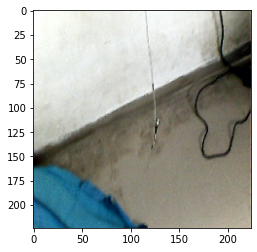

Class is: Mouse Not Detected



In [ ]:

index_num = np.random.randint(0,200)
print(index_num)
predict(combined_train_df, index_num)

